<a href="https://colab.research.google.com/github/Gauravshahare/Variational-Autoencoder-VAE-/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt


In [2]:
batch_size =64

train_dataset = datasets.MNIST(root='./MNIST/',train=True,download=True,
                               transform=transforms.ToTensor())

0it [00:00, ?it/s]

9920512it [00:01, 8848706.28it/s]                            


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 136020.67it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2231985.57it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50546.27it/s]            


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
train = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)  

In [0]:
latent_dim=20
def generate_(batch_size):
    return torch.from_numpy(np.random.multivariate_normal(mean=np.zeros(latent_dim),cov =np.eye(latent_dim),size=batch_size)).type(torch.float)


In [0]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()
    self.bottleneck=nn.Linear(784,400)
    self.mean=nn.Linear(400,latent_dim)
    self.variance=nn.Linear(400,latent_dim)
    self.dec1=nn.Linear(latent_dim,400)
    self.dec2=nn.Linear(400,784)
    
  def encoder(self,x):
    x=F.relu(self.bottleneck(x))
    
    return self.mean(x),self.variance(x)
  
  def decoder(self,x):
    x=F.relu(self.dec1(x))
    x=torch.sigmoid(self.dec2(x))
    return x
  
  
  def sample(self,mu,sigma):
    
    sigma = torch.exp(0.5*sigma).to(device) # To make variance greater than zero
    normal = generate_(batch_size).to(device)        
    return mu + sigma*normal
  
  def forward(self,x):
    mu,sigma = self.encoder(x)
    z = self.sample(mu,sigma).to(device)
    z = self.decoder(z)
    return mu,sigma,z
  

In [0]:
def Loss(mu,sigma,recon_x,x,normal=False):
    loss = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    error =0
    if(normal):
        error =  F.mse_loss(recon_x,x)
    else:
        error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    return loss+error

In [0]:
# Check availabilty of device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
num_epochs = 50
loss_list = []
for epoch in range(num_epochs):
    loss=0
    for i ,(images,target) in enumerate(train):

        batch_size = images.size(0)
        images = images.view(batch_size, -1).to(device)
        images = Variable(images,requires_grad =False)

        
        # set grad to zero
        optimizer.zero_grad()
        
        # Model training and Loss calculation
        mu,sigma,z = model(images)
        i_loss = Loss(mu,sigma,z,images)
        loss+=i_loss.item()
        i_loss.backward()
        optimizer.step()
        # accuracy

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                      .format(epoch, num_epochs, i+1, 938, i_loss.item()))
    loss_list.append(loss)

Epoch [0/50], Step [200/938], Loss: 10346.1436
Epoch [0/50], Step [400/938], Loss: 8783.9912
Epoch [0/50], Step [600/938], Loss: 8026.3862
Epoch [0/50], Step [800/938], Loss: 7314.1006
Epoch [1/50], Step [200/938], Loss: 7357.7129
Epoch [1/50], Step [400/938], Loss: 7000.6201
Epoch [1/50], Step [600/938], Loss: 7411.6846
Epoch [1/50], Step [800/938], Loss: 7343.2861
Epoch [2/50], Step [200/938], Loss: 7214.2988
Epoch [2/50], Step [400/938], Loss: 6967.8398
Epoch [2/50], Step [600/938], Loss: 7122.0820
Epoch [2/50], Step [800/938], Loss: 6592.3750
Epoch [3/50], Step [200/938], Loss: 7447.5034
Epoch [3/50], Step [400/938], Loss: 7014.9224
Epoch [3/50], Step [600/938], Loss: 6721.7539
Epoch [3/50], Step [800/938], Loss: 6626.9951
Epoch [4/50], Step [200/938], Loss: 7262.2612
Epoch [4/50], Step [400/938], Loss: 6986.7480
Epoch [4/50], Step [600/938], Loss: 7445.4023
Epoch [4/50], Step [800/938], Loss: 6813.7773
Epoch [5/50], Step [200/938], Loss: 6681.6040
Epoch [5/50], Step [400/938], Los

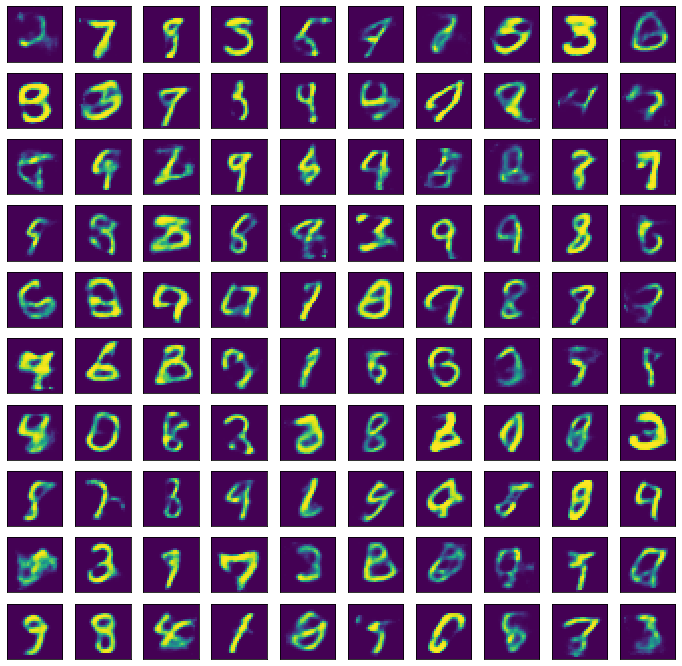

In [26]:
z = generate_(100).to(device)
generated_images = Variable(model.decoder(z),requires_grad =False)
z= generated_images.reshape((100,28,28))
z=z.cpu().detach().numpy()
fig=plt.figure(figsize=(12, 12))

columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = z[i-1]
    fig.add_subplot(rows, columns,i)
    
    show = plt.imshow(img)
    show.axes.get_xaxis().set_visible(False)
    show.axes.get_yaxis().set_visible(False)
plt.savefig('result.jpg')
plt.show()
